In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms, utils
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageChops
import torchvision.transforms as transforms
from google.colab import files
import numpy as np

import matplotlib.pyplot as plt
from IPython import display
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.optim import lr_scheduler
import time
import os
import copy
import torchvision
!pip install --quiet lightning-bolts
!pip install --quiet git+https://github.com/greentfrapp/lucent.git
from lucent.optvis import render, param, transform, objectives
from pl_bolts.models.self_supervised import SimCLR # per carregar el model auto-supervisat (SimCLR)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from torchsummary import summary
import numpy as np
from skimage.feature import local_binary_pattern
from PIL import Image

     |████████████████████████████████| 316 kB 32.4 MB/s 
     |████████████████████████████████| 585 kB 68.6 MB/s 
     |████████████████████████████████| 418 kB 58.3 MB/s 
     |████████████████████████████████| 140 kB 54.9 MB/s 
     |████████████████████████████████| 596 kB 61.1 MB/s 
     |████████████████████████████████| 1.1 MB 47.8 MB/s 
     |████████████████████████████████| 144 kB 63.5 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |████████████████████████████████| 271 kB 64.2 MB/s 
     |████████████████████████████████| 225 kB 28.6 MB/s 
     |████████████████████████████████| 297 kB 69.0 MB/s 
     |████████████████████████████████| 297 kB 77.6 MB/s 
     |████████████████████████████████| 297 kB 83.7 MB/s 
     |████████████████████████████████| 296 kB 57.5 MB/s 
     |████████████████████████████████| 296 kB 67.7 MB/s 
     |████████████████████████████████| 280 kB 69.1 MB/s 
     |████████████████████████████████| 280 kB 66.3 MB/s 
     |██████████

In [3]:
resnet50 = torchvision.models.resnet50(pretrained = True, progress = True)
weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'
resnet50_ss = SimCLR.load_from_checkpoint(weight_path, strict=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50.to(device).eval()
resnet50_ss.to(device).eval()
summary(resnet50, (3, 224, 224))
summary(resnet50_ss, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading: "https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt" to /root/.cache/torch/hub/checkpoints/simclr_imagenet.ckpt


  0%|          | 0.00/229M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/saving.py:218: UserWarning: Found keys that are not in the model state dict but in the checkpoint: ['non_linear_evaluator.block_forward.2.weight', 'non_linear_evaluator.block_forward.2.bias']
  f"Found keys that are not in the model state dict but in the checkpoint: {keys.unexpected_keys}"


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

# FEATURE INVERSION

In [4]:
from lucent.misc.io import show
@objectives.wrap_objective()
def dot_compare(layer, batch=1, cossim_pow=0):
  def inner(T):
    dot = (T(layer)[batch] * T(layer)[0]).sum()
    mag = torch.sqrt(torch.sum(T(layer)[0]**2))
    cossim = dot/(1e-6 + mag)
    return -dot * cossim ** cossim_pow
  return inner

def feature_inversion_super(img, layer=None, n_steps=512, cossim_pow=0.0):
  # Convert image to torch.tensor and scale image
  img = torch.tensor(np.transpose(img, [2, 0, 1])).to(device)
  img = torch.clone(img).detach().requires_grad_(True).to(device)
  upsample = torch.nn.Upsample(224)
  img = upsample(img)
  
  obj = objectives.Objective.sum([
    1.0 * dot_compare(layer, cossim_pow=cossim_pow),
    objectives.blur_input_each_step(),
  ])

  # Initialize parameterized input and stack with target image
  # to be accessed in the objective function
  params, image_f = param.image(224)
  def stacked_param_f():
    return params, lambda: torch.stack([image_f()[0], img])

  transforms = [
    transform.pad(8, mode='constant', constant_value=.5),
    transform.jitter(8),
    transform.random_scale([0.9, 0.95, 1.05, 1.1] + [1]*4),
    transform.random_rotate(list(range(-5, 5)) + [0]*5),
    transform.jitter(2),
  ]

  _ = render.render_vis(resnet50, obj, stacked_param_f, transforms=transforms, thresholds=(n_steps,), show_image=True, progress=False)

  show(_[0][0])
def feature_inversion_super_self_supervised(img, layer=None, n_steps=512, cossim_pow=0.0):
  # Convert image to torch.tensor and scale image
  img = torch.tensor(np.transpose(img, [2, 0, 1])).to(device)
  img = torch.clone(img).detach().requires_grad_(True).to(device)
  upsample = torch.nn.Upsample(224)
  img = upsample(img)
  
  obj = objectives.Objective.sum([
    1.0 * dot_compare(layer, cossim_pow=cossim_pow),
    objectives.blur_input_each_step(),
  ])

  # Initialize parameterized input and stack with target image
  # to be accessed in the objective function
  params, image_f = param.image(224)
  def stacked_param_f():
    return params, lambda: torch.stack([image_f()[0], img])

  transforms = [
    transform.pad(8, mode='constant', constant_value=.5),
    transform.jitter(8),
    transform.random_scale([0.9, 0.95, 1.05, 1.1] + [1]*4),
    transform.random_rotate(list(range(-5, 5)) + [0]*5),
    transform.jitter(2),
  ]

  _ = render.render_vis(resnet50_ss, obj, stacked_param_f, transforms=transforms, thresholds=(n_steps,), show_image=True, progress=False)

  show(_[0][0])

Primera imatge aplicada al model supervisat

(224, 224, 3)



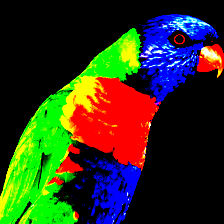

In [12]:
import torchvision.transforms as T
img = Image.open("/content/drive/MyDrive/Colab Notebooks/n01820546_1591.JPEG")
preprocess = T.Compose([
   T.Resize(224),
   T.CenterCrop(224),
   T.ToTensor(),
   T.Normalize(mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225])
   ])

img = preprocess(img)
img.cpu().detach()
img=np.array(img, np.float32)
img = img.transpose((1, 2, 0))
print(img.shape)

show(img)


conv1



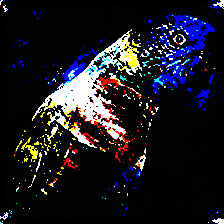


bn1



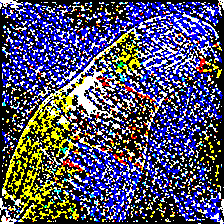


relu



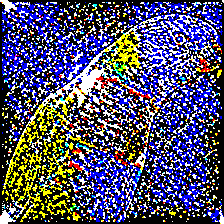


layer1



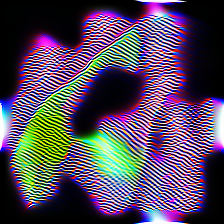


layer2



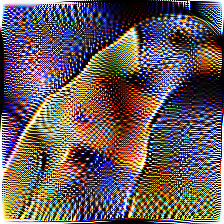


layer3



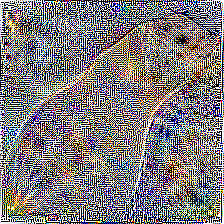


layer4_2_relu



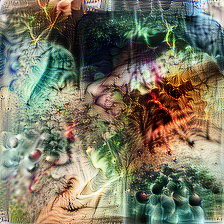


maxpool



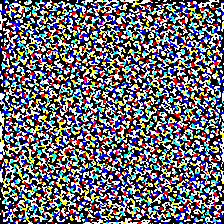

In [14]:

print('conv1')
feature_inversion_super(img/255, layer='conv1')
print()
print('bn1')
feature_inversion_super(img/255, layer='bn1')
print()
print('relu')
feature_inversion_super(img/255, layer='relu')
print()
print('layer1')
feature_inversion_super(img/255, layer='layer1')
print()
print('layer2')
feature_inversion_super(img/255, layer='layer2')
print()
print('layer3')
feature_inversion_super(img/255, layer='layer3')
print()
print('layer4_2_relu')
feature_inversion_super(img/255, layer='layer4_2_relu')
print()
print('maxpool')
feature_inversion_super(img/255, layer='maxpool')
print()


Feature inversion per model auto-supervisat

conv1



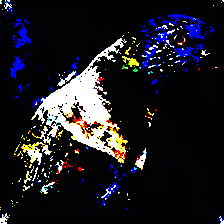


bn1



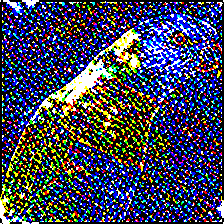


relu



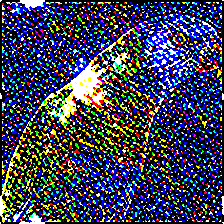


layer1



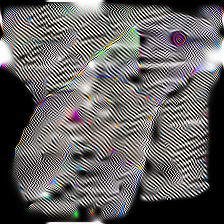


layer2



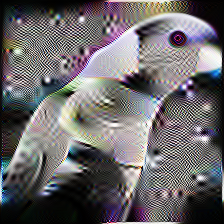


layer3



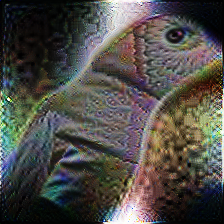


layer4_2_relu



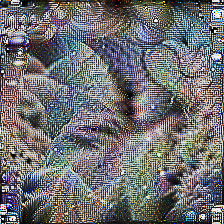


maxpool



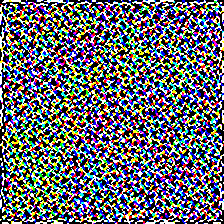

In [17]:
print('conv1')
feature_inversion_super_self_supervised(img/255, layer='encoder_conv1')
print()
print('bn1')
feature_inversion_super_self_supervised(img/255, layer='encoder_bn1')
print()
print('relu')
feature_inversion_super_self_supervised(img/255, layer='encoder_relu')
print()
print('layer1')
feature_inversion_super_self_supervised(img/255, layer='encoder_layer1')
print()
print('layer2')
feature_inversion_super_self_supervised(img/255, layer='encoder_layer2')
print()
print('layer3')
feature_inversion_super_self_supervised(img/255, layer='encoder_layer3')
print()
print('layer4_2_relu')
feature_inversion_super_self_supervised(img/255, layer='encoder_layer4_2_relu')
print()
print('maxpool')
feature_inversion_super_self_supervised(img/255, layer='encoder_maxpool')
print()

Feature inversion amb una altre imatge

(224, 224, 3)



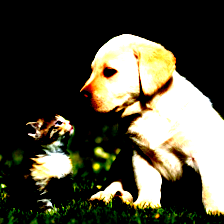

In [6]:
torch.cuda.empty_cache()
import torchvision.transforms as T

!wget -qnc https://i.pinimg.com/originals/44/d9/8c/44d98cccb725fd3a80c0446b9b2e646d.jpg

img = Image.open("44d98cccb725fd3a80c0446b9b2e646d.jpg")
preprocess = T.Compose([
   T.Resize(224),
   T.CenterCrop(224),
   T.ToTensor(),
   T.Normalize(mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225])
   ])

img = preprocess(img)
img.cpu().detach()
img=np.array(img, np.float32)
img = img.transpose((1, 2, 0))
print(img.shape)

show(img)


conv1



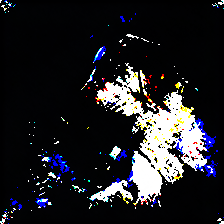


bn1



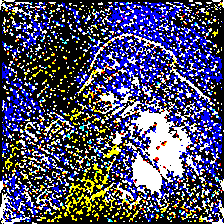


relu



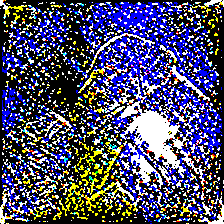


layer1



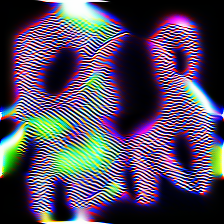


layer2



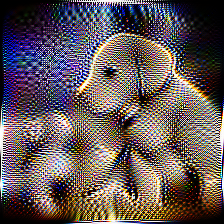


layer3



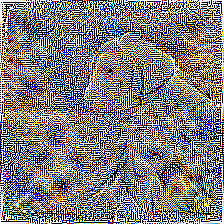


layer4_2_relu



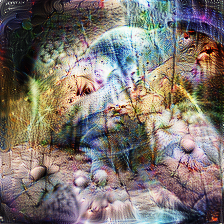


maxpool



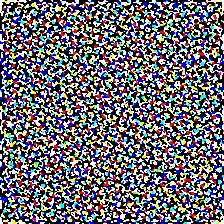

In [19]:
print('conv1')
feature_inversion_super(img/255, layer='conv1')
print()
print('bn1')
feature_inversion_super(img/255, layer='bn1')
print()
print('relu')
feature_inversion_super(img/255, layer='relu')
print()
print('layer1')
feature_inversion_super(img/255, layer='layer1')
print()
print('layer2')
feature_inversion_super(img/255, layer='layer2')
print()
print('layer3')
feature_inversion_super(img/255, layer='layer3')
print()
print('layer4_2_relu')
feature_inversion_super(img/255, layer='layer4_2_relu')
print()
print('maxpool')
feature_inversion_super(img/255, layer='maxpool')
print()


conv1



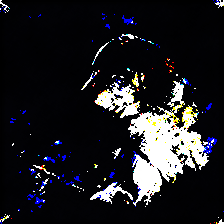


bn1



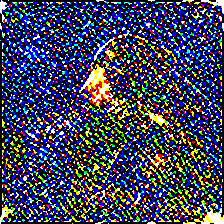


relu



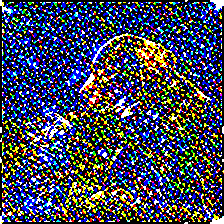


layer1



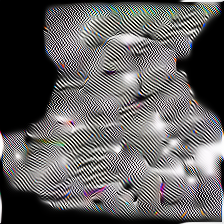


layer2



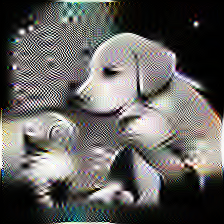


layer3



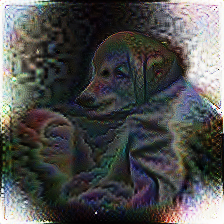


layer4_2_relu



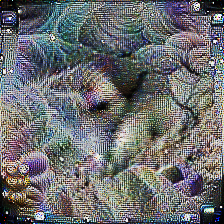


maxpool



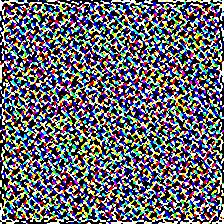

In [7]:
print('conv1')
feature_inversion_super_self_supervised(img/255, layer='encoder_conv1')
print()
print('bn1')
feature_inversion_super_self_supervised(img/255, layer='encoder_bn1')
print()
print('relu')
feature_inversion_super_self_supervised(img/255, layer='encoder_relu')
print()
print('layer1')
feature_inversion_super_self_supervised(img/255, layer='encoder_layer1')
print()
print('layer2')
feature_inversion_super_self_supervised(img/255, layer='encoder_layer2')
print()
print('layer3')
feature_inversion_super_self_supervised(img/255, layer='encoder_layer3')
print()
print('layer4_2_relu')
feature_inversion_super_self_supervised(img/255, layer='encoder_layer4_2_relu')
print()
print('maxpool')
feature_inversion_super_self_supervised(img/255, layer='encoder_maxpool')
print()

layer4_downtown_0



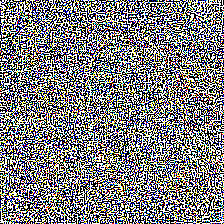


layer4_downtown_0



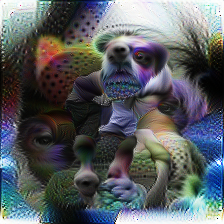


layer3_conv2



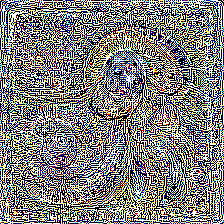


layer3_conv2



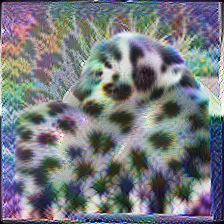

In [10]:
print('layer4_downtown_0')
feature_inversion_super(img/255, layer='layer4_0_downsample_0')
print()
print('layer4_downtown_0')
feature_inversion_super_self_supervised(img/255, layer='encoder_layer4_0_downsample_0')
print()
print('layer3_conv2')
feature_inversion_super(img/255, layer='layer3_3_conv2')
print()
print('layer3_conv2')
feature_inversion_super_self_supervised(img/255, layer='encoder_layer3_3_conv2')
print()